In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
from itertools import product
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import torch.nn.init as init

In [2]:
#check for GPU availability
torch.cuda.is_available()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Define Functions

## 1) function to preprocess (1-hot encode) MONK data

In [3]:
def preprocess_monk(file_name):
    '''
    Load data from the Monk dataset and preprocess using one-hot encoding.

    Parameters:
    - file_name (str): The file name of the dataset.

    Returns:
    - x (torch.Tensor): Input data after one-hot encoding.
    - y (torch.Tensor): Target data.
    '''

    # load the dataset, split into input (X) and output (y) variables
    df = pd.read_csv(file_name, delimiter=' ', header=None,
                     names=['_','target', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'data_number'],
                     index_col=False)

    # Extract input features and target variable
    x1, x2, x3, x4, x5, x6, target = (np.array(df[feature]) for feature in ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'target'])

    # Initialize OneHotEncoder
    encoder = OneHotEncoder(sparse_output=False)

    # Reshape and transform x1 using one-hot encoding
    input_one_hot = encoder.fit_transform(x1.reshape(-1, 1))

    # Loop through the remaining input features and concatenate one-hot encoded values
    for x in [x2,x3,x4,x5,x6]:
        data =x.reshape(-1, 1)
        one_hot_encoded = encoder.fit_transform(data)
        input_one_hot = np.hstack((input_one_hot, one_hot_encoded))

    # Convert to PyTorch tensors
    x = torch.tensor(input_one_hot, dtype=torch.float32)#.cuda()
    y = torch.tensor(target, dtype=torch.float32).reshape(-1,1)#.cuda()

    return x, y

## Function to plot training curves

In [4]:
def plot_training_curves(epoch, train_losses, test_losses, train_accuracies, test_accuracies, hyperparams):
    '''
    Plot training and test curves for loss and accuracy.

    Parameters:
    - epoch (int): The number of epochs.
    - train_losses (list): List of training losses for each epoch.
    - test_losses (list): List of test losses for each epoch.
    - train_accuracies (list): List of training accuracies for each epoch.
    - test_accuracies (list): List of test accuracies for each epoch.
    - hyperparams (list): List of hyperparameters [hidden_units, lr, alpha, batch_size, lambda].

    Returns:
    None
    '''
    plt.figure(figsize=(12, 4))
    plt.suptitle(f'Batch Size={hyperparams[3]}, Hidden Units={hyperparams[0]}, Eta={hyperparams[1]}, Alpha={hyperparams[2]}, Lambda={hyperparams[4]}')
    # Loss plots
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epoch + 2), train_losses, label='Training Loss', color = 'red')
    plt.plot(range(1, epoch + 2), test_losses, label='Test Loss', color = 'blue', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy plots
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epoch + 2), train_accuracies, label='Training Accuracy', color='red')
    plt.plot(range(1, epoch + 2), test_accuracies, label='Test Accuracy', color = 'blue', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Define the model

In [5]:
# Define the classifier

class MonkClassifier(nn.Module):
    def __init__(self, hidden_size, input_size=17, output_size=1):
        super(MonkClassifier, self).__init__()

        # Custom weight initialization function
        #def init_weights(m):
        #    if type(m) == nn.Linear:
        #        if hasattr(m, 'weight') and m.weight is not None:
        #            init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
        #            if m.bias is not None:
        #               init.constant_(m.bias, 0)

        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

        # Apply custom weight initialization to linear layers
        #self.apply(init_weights)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        output = self.sigmoid(x)
        return output

In [6]:
def training_model(x_train, y_train, x_test, y_test, hidden_size,learning_rate, momentum, bs, reg_coeff, num_epochs=1000, plot_curves=False):
    '''
    Train a Monk classifier model.

    Parameters:
    - x_train (torch.Tensor): Training input data.
    - y_train (torch.Tensor): Training target data.
    - x_test (torch.Tensor): Test (or Validation) input data.
    - y_test (torch.Tensor): Test (or Validation) target data.
    - hidden_size (int): Size of the hidden layer in the model.
    - learning_rate (float): Learning rate for the optimizer.
    - momentum (float): Momentum for the optimizer.
    - batch_size (int): Batch size for training and testing.
    - reg_coeff (float): Regularization coefficient for weight decay.
    - num_epochs (int): Maximum number of training epochs (default: 1000).
    - plot_curves (bool): Whether to plot training curves (default: False).

    Returns:
    - epoch (int): Number of epochs completed.
    - train_loss (float): Final training loss.
    - test_loss (float): Final test (or validation) loss.
    - train_accuracy (float): Final training accuracy.
    - test_accuracy (float): Final test (or validation) accuracy.
    '''

    # Create an instance of the model
    model = MonkClassifier(hidden_size)
    #model.to(device)
    # Define the loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=reg_coeff)

    train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True)

    # Lists to store training and test losses for plotting
    train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []

    # parameters to stop at training convergence
    prev_loss = float('inf')
    #prev_accuracy = 0
    patience_counter, patience = 0, 20

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        for inputs, labels in train_dataloader:
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels) #Compute the loss

            optimizer.zero_grad()   # Zero the gradients
            loss.backward() # Backward pass
            optimizer.step()  # Update weights

        model.eval()  # Set the model to evaluation mode
        #calculate loss
        y_pred = model(x_train)
        train_loss = criterion(y_pred, y_train)
        # Calculate accuracy
        predicted_labels = torch.round(y_pred)
        correct_predictions = (predicted_labels == y_train).sum().item()
        total_samples = y_train.size(0)
        accuracy = correct_predictions / total_samples

        train_losses.append(train_loss.item())
        train_accuracies.append(accuracy)
        # Evaluation on the test/validation set
        with torch.no_grad():
            test_outputs = model(x_test)
            test_loss = criterion(test_outputs, y_test)

            # Calculate test accuracy
            predicted_test_labels = torch.round(test_outputs)
            correct_test_predictions = (predicted_test_labels == y_test).sum().item()
            total_test_samples = y_test.size(0)
            test_accuracy = correct_test_predictions / total_test_samples

            test_accuracies.append(test_accuracy)
            test_losses.append(test_loss.item())

        print(f'Training - Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss.item():.4f}, '
            f'Accuracy: {accuracy:.4f} | Test - Epoch [{epoch+1}/{num_epochs}], '
            f'Loss: {test_loss.item():.4f} Accuracy: {test_accuracy:.4f} ', end='\r')

        # Check for convergence
        if abs(prev_loss - train_loss.item()) < 1e-5:
            patience_counter += 1
        else:
            patience_counter = 0

        if patience_counter == patience:
        #    print(f"Convergence reached. at epoch {epoch+1} Stopping training.")
            break
        prev_loss = train_loss.item()

    print(f'\n N. Epochs = {epoch+1} - Loss (train | test)= ({train_loss.item():.4} | {test_loss.item():.4}) - Accuracy (train | test) = ({accuracy} | {test_accuracy})')

    if plot_curves:
        hyperparams = [hidden_size,learning_rate, momentum, bs, reg_coeff, num_epochs]
        plot_training_curves(epoch, train_losses, test_losses, train_accuracies, test_accuracies, hyperparams)

    return epoch+1, train_loss.item(), test_loss.item(), accuracy, test_accuracy

In [7]:
def perform_grid_search_kfold(hidden_sizes, learning_rates, momentums, batch_sizes, reg_coeffs, k_folds, x, y, plot_curves=False, num_epochs=1000):
    '''
    Perform grid search with k-fold cross-validation for Monk classifier hyperparameters.

    Parameters:
    - hidden_sizes (list): List of hidden layer sizes to explore.
    - learning_rates (list): List of learning rates to explore.
    - momentums (list): List of momentum values to explore.
    - batch_sizes (list): List of batch sizes to explore.
    - reg_coeffs (list): List of regularization coefficients to explore.
    - k_folds (int): Number of folds for cross-validation.
    - x (torch.Tensor): Input data.
    - y (torch.Tensor): Target data.
    - plot_curves (bool): Whether to plot training curves for each hyperparameter combination (default: False).

    Returns:
    - best_hyperparams (list): List of best hyperparameters based on highest average validation accuracy.
    '''

    best_acc = 0
    best_hyperparams = []

    for hidden_size, learning_rate, momentum, bs, reg_coeff in product(hidden_sizes,learning_rates,momentums,batch_sizes, reg_coeffs):
        print(f'hidden_size={hidden_size}; lr={learning_rate}; alpha = {momentum}; batch size = {bs}; lambda = {reg_coeff}')

        kf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

        # Lists to store training and validation losses and accuracies for each epoch
        train_losses, val_losses, train_acc, val_acc = [], [], [], []

        # Perform K-fold cross-validation
        for fold, (train_indices, val_indices) in enumerate(kf.split(x,y)):
            #print(f"\nFold {fold + 1}/{k_folds}")

            # Split the data into training and validation (or test) sets
            X_train, X_val = x[train_indices], x[val_indices]
            Y_train, Y_val = y[train_indices], y[val_indices]

            max_epoch, average_loss, average_val_loss, average_accuracy, average_val_accuracy = training_model(
                x_train=X_train, y_train=Y_train, x_test=X_val, y_test=Y_val,
                hidden_size=hidden_size, learning_rate=learning_rate, momentum=momentum,
                bs=bs, reg_coeff=reg_coeff, plot_curves=plot_curves, num_epochs=num_epochs)

            train_losses.append(average_loss)
            val_losses.append(average_val_loss)
            train_acc.append(average_accuracy)
            val_acc.append(average_val_accuracy)

        print(f'Final Results: hidden_size={hidden_size}; lr={learning_rate}; alpha = {momentum}; batch size = {bs}; lambda = {reg_coeff} --> '
            f'train_loss = {np.mean(train_losses):.4} +- {np.std(train_losses):.4} | '
            f'val_loss = {np.mean(val_losses):.4} +- {np.std(val_losses):.4}'
            f'train_acc = {np.mean(train_acc):.4} +- {np.std(train_acc):.4} | '
            f'val_acc = {np.mean(val_acc):.4} +- {np.std(val_acc):.4}')

        if np.mean(val_acc) >= best_acc:
            best_acc = np.mean(val_acc)
            best_hyperparams = [hidden_size, learning_rate, momentum, bs, reg_coeff]

    print(best_hyperparams)
    return best_hyperparams

In [8]:
def train_with_different_initializations(x_train, y_train, x_test, y_test,
                                         hidden_size,learning_rate, momentum,
                                         bs, reg_coeff, num_epochs=1000,
                                         plot_curves=False, N = 5):
    '''
    train the model N times with different weight initializations,
    to estimate the model performances with mean and variance
    '''
    train_losses, test_losses, train_accs, test_accs = [], [], [], []
    for i in range (0,N):
        _, train_loss, test_loss, train_acc, test_acc = training_model(x_train,
                        y_train,
                        x_test,
                        y_test,
                        hidden_size,
                        learning_rate,
                        momentum,
                        bs,
                        reg_coeff,
                        plot_curves=plot_curves,
                        num_epochs=num_epochs)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

    print(f'Train Loss: {np.mean(train_losses):.4} +- {np.std(train_losses):.4}')
    print(f'Test Loss: {np.mean(test_losses):.4} +- {np.std(test_losses):.4}')
    print(f'Train Acc: {np.mean(train_accs)*100:.4} +- {np.std(train_accs)*100:.4} %')
    print(f'Test Acc: {np.mean(test_accs)*100:.4} +- {np.std(test_accs)*100:.4} %')


# Monk 1

In [14]:
x_train, y_train = preprocess_monk(file_name='monk_data/monks-1.train')
x_test, y_test = preprocess_monk(file_name='monk_data/monks-1.test')

print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

torch.Size([124, 17])
torch.Size([124, 1])
torch.Size([432, 17])
torch.Size([432, 1])


## Perform Model Selection using a grid serch with k-fold cross validation

inizialmente modificare gli iperparametri ad occhio per avere un'idea di cosa succede,
poi fare una grid search più fine 

In [15]:
hidden_sizes = [5]
learning_rates = [0.01]
momentums = [0.9]
batch_sizes = [4]
reg_coeffs = [0]


best_hp = perform_grid_search_kfold(hidden_sizes,
                                    learning_rates,
                                    momentums,
                                    batch_sizes,
                                    reg_coeffs,
                                    k_folds=5,
                                    x=x_train,
                                    y=y_train,
                                    plot_curves=False)

hidden_size=5; lr=0.01; alpha = 0.9; batch size = 4; lambda = 0
Training - Epoch [377/1000], Loss: 0.0013, Accuracy: 1.0000 | Test - Epoch [377/1000], Loss: 0.0751 Accuracy: 0.9200 
 N. Epochs = 377 - Loss (train | test)= (0.001294 | 0.07511) - Accuracy (train | test) = (1.0 | 0.92)
Training - Epoch [1000/1000], Loss: 0.0115, Accuracy: 0.9899 | Test - Epoch [1000/1000], Loss: 0.1636 Accuracy: 0.8400 
 N. Epochs = 1000 - Loss (train | test)= (0.01155 | 0.1636) - Accuracy (train | test) = (0.98989898989899 | 0.84)
Training - Epoch [337/1000], Loss: 0.0011, Accuracy: 1.0000 | Test - Epoch [337/1000], Loss: 0.0488 Accuracy: 0.9600 
 N. Epochs = 337 - Loss (train | test)= (0.001115 | 0.04883) - Accuracy (train | test) = (1.0 | 0.96)
Training - Epoch [302/1000], Loss: 0.0010, Accuracy: 1.0000 | Test - Epoch [302/1000], Loss: 0.0061 Accuracy: 1.0000 
 N. Epochs = 302 - Loss (train | test)= (0.001032 | 0.006148) - Accuracy (train | test) = (1.0 | 1.0)
Training - Epoch [425/1000], Loss: 0.0011,

## Train the model (with best hyperparameters) using different weights initiaizatons
in order to estimate a mean and variance for the performance

In [17]:
train_with_different_initializations(x_train=x_train,
               y_train=y_train,
               x_test=x_test,
               y_test=y_test,
               hidden_size=best_hp[0],
               learning_rate=best_hp[1],
               momentum=best_hp[2],
               bs = best_hp[3],
               reg_coeff= best_hp[4],
               plot_curves=False)

Training - Epoch [317/1000], Loss: 0.0011, Accuracy: 1.0000 | Test - Epoch [317/1000], Loss: 0.0018 Accuracy: 1.0000 
 N. Epochs = 317 - Loss (train | test)= (0.001135 | 0.001776) - Accuracy (train | test) = (1.0 | 1.0)
Training - Epoch [278/1000], Loss: 0.0008, Accuracy: 1.0000 | Test - Epoch [278/1000], Loss: 0.0016 Accuracy: 1.0000 
 N. Epochs = 278 - Loss (train | test)= (0.0008484 | 0.001589) - Accuracy (train | test) = (1.0 | 1.0)
Training - Epoch [261/1000], Loss: 0.0012, Accuracy: 1.0000 | Test - Epoch [261/1000], Loss: 0.0049 Accuracy: 1.0000 
 N. Epochs = 261 - Loss (train | test)= (0.001219 | 0.004877) - Accuracy (train | test) = (1.0 | 1.0)
Training - Epoch [222/1000], Loss: 0.0008, Accuracy: 1.0000 | Test - Epoch [222/1000], Loss: 0.0052 Accuracy: 1.0000 
 N. Epochs = 222 - Loss (train | test)= (0.0008362 | 0.00516) - Accuracy (train | test) = (1.0 | 1.0)
Training - Epoch [210/1000], Loss: 0.0009, Accuracy: 1.0000 | Test - Epoch [210/1000], Loss: 0.0029 Accuracy: 1.0000 
 

# Retrain the model to make final plots

Training - Epoch [258/1000], Loss: 0.0010, Accuracy: 1.0000 | Test - Epoch [258/1000], Loss: 0.0020 Accuracy: 1.0000 
 N. Epochs = 258 - Loss (train | test)= (0.0009663 | 0.001963) - Accuracy (train | test) = (1.0 | 1.0)


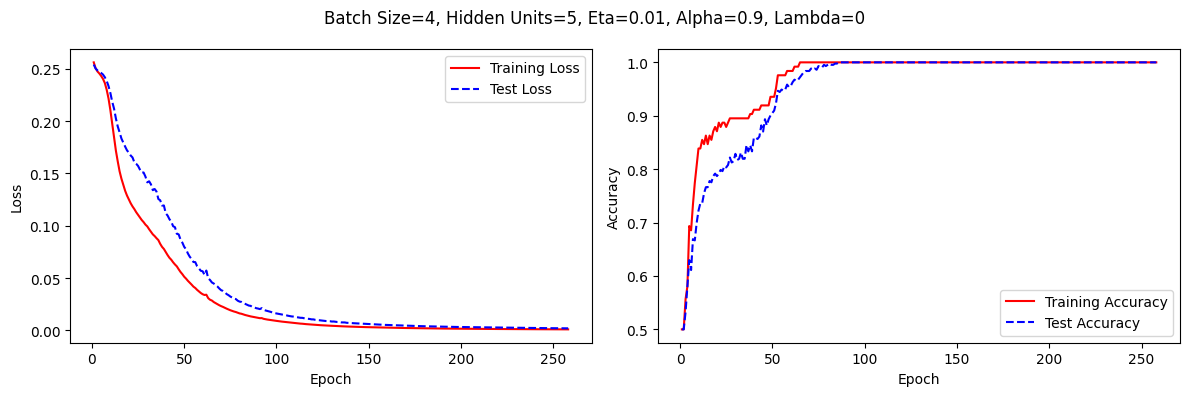

(258, 0.0009663382079452276, 0.0019634547643363476, 1.0, 1.0)

In [ ]:
# train the model on all the test set using the best hyperparameters found

training_model(x_train=x_train,
               y_train=y_train,
               x_test=x_test,
               y_test=y_test,
               hidden_size=best_hp[0],
               learning_rate=best_hp[1],
               momentum=best_hp[2],
               bs = best_hp[3],
               reg_coeff= best_hp[4],
               plot_curves=True)

# Monk 2

In [68]:
x_train, y_train = preprocess_monk(file_name='monk_data/monks-2.train')
x_test, y_test = preprocess_monk(file_name='monk_data/monks-2.test')

In [69]:
hidden_sizes = [4]
learning_rates = [0.1]
momentums = [0.8]
batch_sizes = [4]
reg_coeffs = [0]


best_hp = perform_grid_search_kfold(hidden_sizes,
                                    learning_rates,
                                    momentums,
                                    batch_sizes,
                                    reg_coeffs,
                                    k_folds=5,
                                    x=x_train,
                                    y=y_train,
                                    plot_curves=False)

hidden_size=4; lr=0.1; alpha = 0.8; batch size = 4; lambda = 0
Training - Epoch [125/1000], Loss: 0.0005, Accuracy: 1.0000 | Test - Epoch [125/1000], Loss: 0.0051 Accuracy: 1.0000 
 N. Epochs = 125 - Loss (train | test)= (0.0004638 | 0.005083) - Accuracy (train | test) = (1.0 | 1.0)
Training - Epoch [111/1000], Loss: 0.0005, Accuracy: 1.0000 | Test - Epoch [111/1000], Loss: 0.0007 Accuracy: 1.0000 
 N. Epochs = 111 - Loss (train | test)= (0.0004581 | 0.0007109) - Accuracy (train | test) = (1.0 | 1.0)
Training - Epoch [90/1000], Loss: 0.0003, Accuracy: 1.0000 | Test - Epoch [90/1000], Loss: 0.0003 Accuracy: 1.0000 
 N. Epochs = 90 - Loss (train | test)= (0.0002574 | 0.0003309) - Accuracy (train | test) = (1.0 | 1.0)
Training - Epoch [107/1000], Loss: 0.0004, Accuracy: 1.0000 | Test - Epoch [107/1000], Loss: 0.0007 Accuracy: 1.0000 
 N. Epochs = 107 - Loss (train | test)= (0.0003812 | 0.0007084) - Accuracy (train | test) = (1.0 | 1.0)
Training - Epoch [82/1000], Loss: 0.0003, Accuracy: 1

In [70]:
train_with_different_initializations(x_train=x_train,
               y_train=y_train,
               x_test=x_test,
               y_test=y_test,
               hidden_size=best_hp[0],
               learning_rate=best_hp[1],
               momentum=best_hp[2],
               bs = best_hp[3],
               reg_coeff= best_hp[4],
               plot_curves=False)

Training - Epoch [99/1000], Loss: 0.0004, Accuracy: 1.0000 | Test - Epoch [99/1000], Loss: 0.0005 Accuracy: 1.0000 
 N. Epochs = 99 - Loss (train | test)= (0.0004043 | 0.0004687) - Accuracy (train | test) = (1.0 | 1.0)
Training - Epoch [108/1000], Loss: 0.0004, Accuracy: 1.0000 | Test - Epoch [108/1000], Loss: 0.0004 Accuracy: 1.0000 
 N. Epochs = 108 - Loss (train | test)= (0.0003588 | 0.0003862) - Accuracy (train | test) = (1.0 | 1.0)
Training - Epoch [78/1000], Loss: 0.0002, Accuracy: 1.0000 | Test - Epoch [78/1000], Loss: 0.0002 Accuracy: 1.0000 
 N. Epochs = 78 - Loss (train | test)= (0.0002194 | 0.0002351) - Accuracy (train | test) = (1.0 | 1.0)
Training - Epoch [109/1000], Loss: 0.0003, Accuracy: 1.0000 | Test - Epoch [109/1000], Loss: 0.0003 Accuracy: 1.0000 
 N. Epochs = 109 - Loss (train | test)= (0.0003141 | 0.0003306) - Accuracy (train | test) = (1.0 | 1.0)
Training - Epoch [103/1000], Loss: 0.0003, Accuracy: 1.0000 | Test - Epoch [103/1000], Loss: 0.0006 Accuracy: 1.0000 


Training - Epoch [86/1000], Loss: 0.0003, Accuracy: 1.0000 | Test - Epoch [86/1000], Loss: 0.0003 Accuracy: 1.0000 
 N. Epochs = 86 - Loss (train | test)= (0.0003312 | 0.0003153) - Accuracy (train | test) = (1.0 | 1.0)


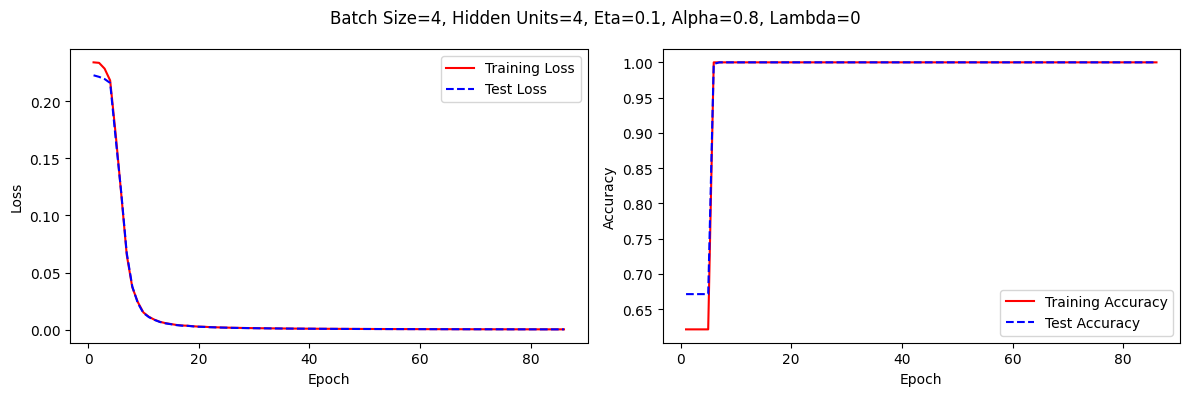

(86, 0.00033123200410045683, 0.000315252342261374, 1.0, 1.0)

In [71]:
# train the model on all the test set using the best hyperparameters found

training_model(x_train=x_train,
               y_train=y_train,
               x_test=x_test,
               y_test=y_test,
               hidden_size=best_hp[0],
               learning_rate=best_hp[1],
               momentum=best_hp[2],
               bs = best_hp[3],
               reg_coeff= best_hp[4],
               plot_curves=True)

# Monk 3 (no regularization)

In [72]:
x_train, y_train = preprocess_monk(file_name='monk_data/monks-3.train')
x_test, y_test = preprocess_monk(file_name='monk_data/monks-3.test')

In [73]:
hidden_sizes = [5]
learning_rates = [0.003]
momentums = [0.9]
batch_sizes = [16]
reg_coeffs = [0]


best_hp = perform_grid_search_kfold(hidden_sizes,
                                    learning_rates,
                                    momentums,
                                    batch_sizes,
                                    reg_coeffs,
                                    k_folds=5,
                                    x=x_train,
                                    y=y_train,
                                    plot_curves=False)

hidden_size=5; lr=0.003; alpha = 0.9; batch size = 16; lambda = 0
Training - Epoch [1000/1000], Loss: 0.0430, Accuracy: 0.9485 | Test - Epoch [1000/1000], Loss: 0.0240 Accuracy: 0.9600 
 N. Epochs = 1000 - Loss (train | test)= (0.04297 | 0.02398) - Accuracy (train | test) = (0.9484536082474226 | 0.96)
Training - Epoch [1000/1000], Loss: 0.0303, Accuracy: 0.9691 | Test - Epoch [1000/1000], Loss: 0.1259 Accuracy: 0.8400 
 N. Epochs = 1000 - Loss (train | test)= (0.03034 | 0.1259) - Accuracy (train | test) = (0.9690721649484536 | 0.84)
Training - Epoch [1000/1000], Loss: 0.0367, Accuracy: 0.9592 | Test - Epoch [1000/1000], Loss: 0.0363 Accuracy: 0.9583 
 N. Epochs = 1000 - Loss (train | test)= (0.03672 | 0.03625) - Accuracy (train | test) = (0.9591836734693877 | 0.9583333333333334)
Training - Epoch [1000/1000], Loss: 0.0215, Accuracy: 0.9796 | Test - Epoch [1000/1000], Loss: 0.1019 Accuracy: 0.8750 
 N. Epochs = 1000 - Loss (train | test)= (0.02148 | 0.1019) - Accuracy (train | test) = (0

In [74]:
train_with_different_initializations(x_train=x_train,
               y_train=y_train,
               x_test=x_test,
               y_test=y_test,
               hidden_size=best_hp[0],
               learning_rate=best_hp[1],
               momentum=best_hp[2],
               bs = best_hp[3],
               reg_coeff= best_hp[4],
               plot_curves=False)

Training - Epoch [1000/1000], Loss: 0.0437, Accuracy: 0.9508 | Test - Epoch [1000/1000], Loss: 0.0461 Accuracy: 0.9537 
 N. Epochs = 1000 - Loss (train | test)= (0.04371 | 0.04613) - Accuracy (train | test) = (0.9508196721311475 | 0.9537037037037037)
Training - Epoch [1000/1000], Loss: 0.0405, Accuracy: 0.9508 | Test - Epoch [1000/1000], Loss: 0.0408 Accuracy: 0.9560 
 N. Epochs = 1000 - Loss (train | test)= (0.04051 | 0.04083) - Accuracy (train | test) = (0.9508196721311475 | 0.9560185185185185)
Training - Epoch [1000/1000], Loss: 0.0424, Accuracy: 0.9508 | Test - Epoch [1000/1000], Loss: 0.0470 Accuracy: 0.9514 
 N. Epochs = 1000 - Loss (train | test)= (0.04244 | 0.04696) - Accuracy (train | test) = (0.9508196721311475 | 0.9513888888888888)
Training - Epoch [1000/1000], Loss: 0.0381, Accuracy: 0.9508 | Test - Epoch [1000/1000], Loss: 0.0376 Accuracy: 0.9606 
 N. Epochs = 1000 - Loss (train | test)= (0.03811 | 0.0376) - Accuracy (train | test) = (0.9508196721311475 | 0.960648148148148

Training - Epoch [2000/2000], Loss: 0.0200, Accuracy: 0.9918 | Test - Epoch [2000/2000], Loss: 0.0341 Accuracy: 0.9583 
 N. Epochs = 2000 - Loss (train | test)= (0.01999 | 0.03412) - Accuracy (train | test) = (0.9918032786885246 | 0.9583333333333334)


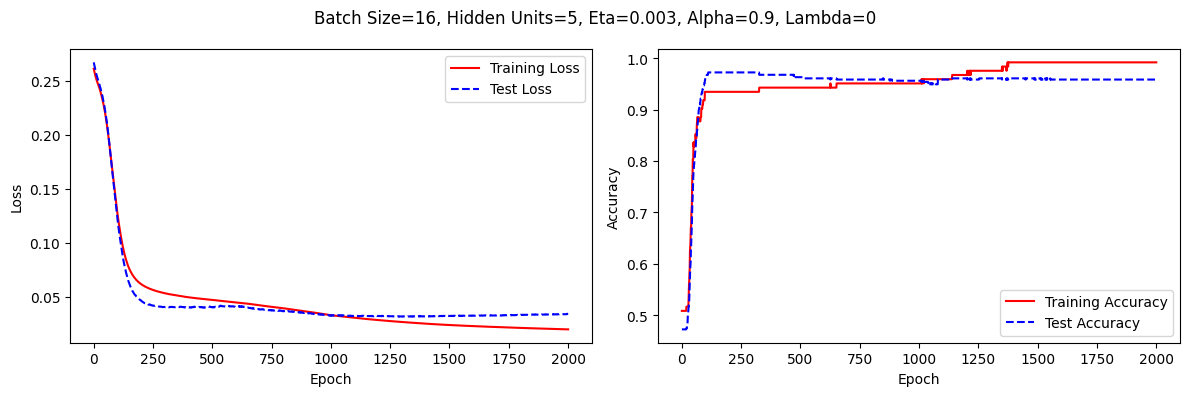

(2000,
 0.019994394853711128,
 0.034117523580789566,
 0.9918032786885246,
 0.9583333333333334)

In [75]:
# train the model on all the test set using the best hyperparameters found

training_model(x_train=x_train,
               y_train=y_train,
               x_test=x_test,
               y_test=y_test,
               hidden_size=best_hp[0],
               learning_rate=best_hp[1],
               momentum=best_hp[2],
               bs = best_hp[3],
               reg_coeff= best_hp[4],
               plot_curves=True,
               num_epochs=2000)

# Monk 3 (with regularization)

In [76]:
x_train, y_train = preprocess_monk(file_name='monk_data/monks-3.train')
x_test, y_test = preprocess_monk(file_name='monk_data/monks-3.test')

In [77]:
hidden_sizes = [5]
learning_rates = [0.003]
momentums = [0.9]
batch_sizes = [16]
reg_coeffs = [0.005]


best_hp = perform_grid_search_kfold(hidden_sizes,
                                    learning_rates,
                                    momentums,
                                    batch_sizes,
                                    reg_coeffs,
                                    k_folds=5,
                                    x=x_train,
                                    y=y_train,
                                    plot_curves=False,
                                    num_epochs=2000)

hidden_size=5; lr=0.003; alpha = 0.9; batch size = 16; lambda = 0.005
Training - Epoch [2000/2000], Loss: 0.0645, Accuracy: 0.9278 | Test - Epoch [2000/2000], Loss: 0.0292 Accuracy: 1.0000 
 N. Epochs = 2000 - Loss (train | test)= (0.06454 | 0.02924) - Accuracy (train | test) = (0.9278350515463918 | 1.0)
Training - Epoch [1529/2000], Loss: 0.0433, Accuracy: 0.9485 | Test - Epoch [1529/2000], Loss: 0.1086 Accuracy: 0.8800 
 N. Epochs = 1529 - Loss (train | test)= (0.04326 | 0.1086) - Accuracy (train | test) = (0.9484536082474226 | 0.88)
Training - Epoch [2000/2000], Loss: 0.0520, Accuracy: 0.9286 | Test - Epoch [2000/2000], Loss: 0.0414 Accuracy: 0.9583 
 N. Epochs = 2000 - Loss (train | test)= (0.05201 | 0.04142) - Accuracy (train | test) = (0.9285714285714286 | 0.9583333333333334)
Training - Epoch [2000/2000], Loss: 0.0298, Accuracy: 0.9592 | Test - Epoch [2000/2000], Loss: 0.1080 Accuracy: 0.8750 
 N. Epochs = 2000 - Loss (train | test)= (0.02983 | 0.108) - Accuracy (train | test) = 

In [78]:
train_with_different_initializations(x_train=x_train,
               y_train=y_train,
               x_test=x_test,
               y_test=y_test,
               hidden_size=best_hp[0],
               learning_rate=best_hp[1],
               momentum=best_hp[2],
               bs = best_hp[3],
               reg_coeff= best_hp[4],
               plot_curves=False,
               num_epochs=3000)

Training - Epoch [716/3000], Loss: 0.0546, Accuracy: 0.9344 | Test - Epoch [716/3000], Loss: 0.0413 Accuracy: 0.9722 
 N. Epochs = 716 - Loss (train | test)= (0.05458 | 0.04134) - Accuracy (train | test) = (0.9344262295081968 | 0.9722222222222222)
Training - Epoch [775/3000], Loss: 0.0525, Accuracy: 0.9344 | Test - Epoch [775/3000], Loss: 0.0411 Accuracy: 0.9699 
 N. Epochs = 775 - Loss (train | test)= (0.0525 | 0.0411) - Accuracy (train | test) = (0.9344262295081968 | 0.9699074074074074)
Training - Epoch [815/3000], Loss: 0.0523, Accuracy: 0.9344 | Test - Epoch [815/3000], Loss: 0.0411 Accuracy: 0.9722 
 N. Epochs = 815 - Loss (train | test)= (0.05233 | 0.04113) - Accuracy (train | test) = (0.9344262295081968 | 0.9722222222222222)
Training - Epoch [737/3000], Loss: 0.0523, Accuracy: 0.9344 | Test - Epoch [737/3000], Loss: 0.0406 Accuracy: 0.9722 
 N. Epochs = 737 - Loss (train | test)= (0.05226 | 0.04056) - Accuracy (train | test) = (0.9344262295081968 | 0.9722222222222222)
Training -

Training - Epoch [845/3000], Loss: 0.0579, Accuracy: 0.9344 | Test - Epoch [845/3000], Loss: 0.0451 Accuracy: 0.9722 
 N. Epochs = 845 - Loss (train | test)= (0.05791 | 0.04511) - Accuracy (train | test) = (0.9344262295081968 | 0.9722222222222222)


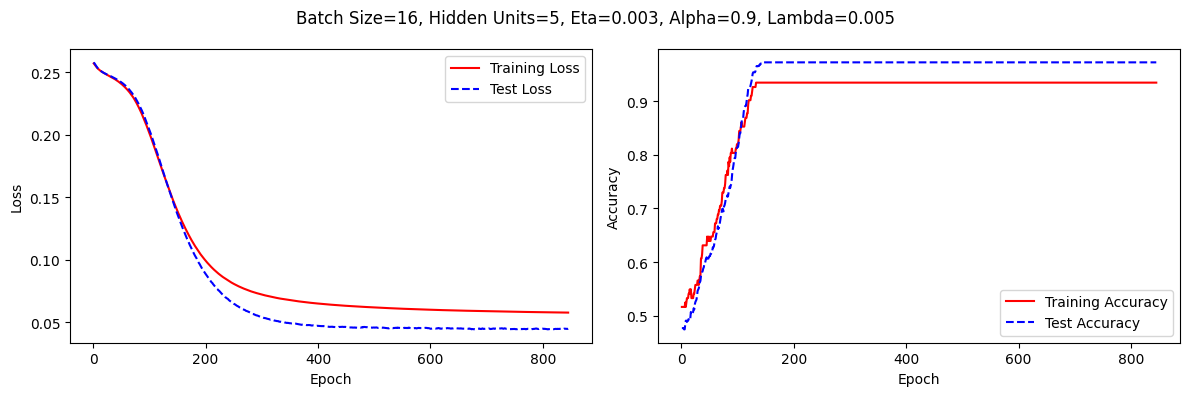

(845,
 0.05790518596768379,
 0.04510823264718056,
 0.9344262295081968,
 0.9722222222222222)

In [79]:
# train the model on all the test set using the best hyperparameters found

training_model(x_train=x_train,
               y_train=y_train,
               x_test=x_test,
               y_test=y_test,
               hidden_size=best_hp[0],
               learning_rate=best_hp[1],
               momentum=best_hp[2],
               bs = best_hp[3],
               reg_coeff= best_hp[4],
               plot_curves=True,
               num_epochs=3000)